In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import moex

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 6]
#plt.rcParams['figure.dpi'] = 200 # 200

In [2]:
def remove_suffix(series):
    rep_pattern = '|'.join(('ао', 'ап', '-п', '-гдр', '-адр', ' др'))
    a = series.str.replace(rep_pattern, '')
    return a.str.rstrip('3').str.rstrip('-').str.rstrip(' ')

In [3]:
# Грузим стоки с Мос.Биржи
imoex = moex.get_stocks_in_indices('IMOEX')

# Чистим наименования от суффиксов
imoex['shortnames'] = remove_suffix(imoex['shortnames'])

# Группируем по компаниям
imoex = imoex.groupby('shortnames').sum().sort_values('weight', ascending=False)
# Приводим веса к числу с плавующей точнокй
imoex['weight'] = imoex['weight']/100

https://iss.moex.com/iss/statistics/engines/stock/markets/index/analytics/IMOEX.csv?iss.only=analytics&limit=100&start=0


# Расчитываем свой индекс
$$w_i=\frac {\frac{1}{n} + W_i^{[IMOEX]}}{1+\sum_{k=1}^n{W_k^{[IMOEX]}}}$$

In [4]:
imoex['imyMOEX'] = (1/imoex['weight'].count()+ imoex['weight'])/(1+imoex['weight'].sum())

## Загрузка портфеля

In [5]:
b = {
'АЛРОСА ао':25783.9,
'Аэрофлот':18662.8,
'ВТБ ао':20198.7,
'ГАЗПРОМ ао':20102.5,
'ГМКНорНик':21578,
'ДетскийМир':24228.4,
'ИнтерРАОао':20604,
'ЛСР ао':22770,
'ЛУКОЙЛ':20308,
'Магнит ао':24985,
'МКБ ао':19730.7,
'ММК':25326,
'МосБиржа':21385,
'МТС-ао':19209,
'НЛМК ао':25113.4,
'Новатэк ао':21765.6,
'ПИК ао':29840,
'Полюс':14502,
'Роснефть':26979,
'Россети ао':16958.5,
'Ростел -ао':19015.5,
'РУСАЛ ао':24644.4,
'РусГидро':20298.2,
'Сбербанк':23873.5,
'СевСт-ао':23704.8,
'Система ао':30763,
'Сургнфгз':22606.5,
'Татнфт 3ао':20759.1,
'ФосАгро ао':21098,
'ФСК ЕЭС ао':20152,
'Юнипро ао':19425,
'FIVE-гдр':21940,
'iQIWI':4450,
'MAIL-гдр':15575,
'Polymetal':14312.7,
'TCS-гдр':30420,
'Yandex clA':31804.8,
'КМЗ':621.00,
'Лента др':13158.0,   
}

In [6]:
c = pd.DataFrame(b.items(), columns=['shortnames','portfolio'])
c['shortnames'] = remove_suffix(c['shortnames'])
# Группируем по компаниям
c = c.groupby('shortnames').sum().sort_values('portfolio', ascending=False)
c['portfolio']=c['portfolio']/c['portfolio'].sum()

## Сравнение

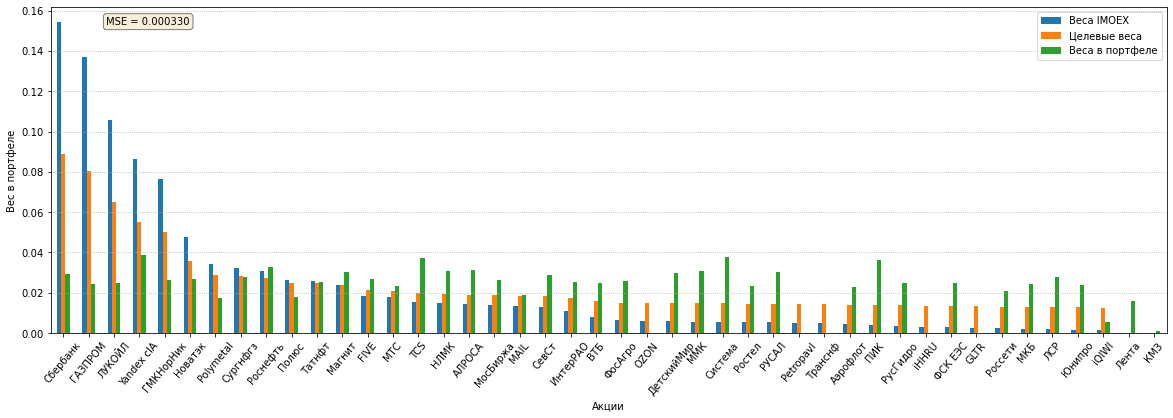

In [7]:
imoex = pd.concat([imoex,c], axis=1)
imoex.fillna(0, inplace=True)

m = imoex['imyMOEX']-imoex['portfolio']
mse = (m**2).mean()

ax = imoex.plot.bar(rot=50)
ax.grid(axis='y', linestyle=':')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.97, f"MSE = {mse:0.6f}", transform=ax.transAxes, verticalalignment='top', bbox=props)
ax.set_ylabel('Вес в портфеле')
ax.set_xlabel('Акции')

plt.legend(labels=['Веса IMOEX', 'Целевые веса', 'Веса в портфеле'])

## Приоритет покупки новых акций

In [8]:
(m/imoex['imyMOEX']*100).sort_values(ascending=False)

Petropavl     100.000000
GLTR          100.000000
iHHRU         100.000000
OZON          100.000000
Транснф       100.000000
ГАЗПРОМ        69.441001
Сбербанк       67.235502
ЛУКОЙЛ         61.750483
iQIWI          56.703559
ГМКНорНик      47.446737
Polymetal      39.618730
Yandex clA     29.369374
Полюс          29.296926
Новатэк        25.431780
Сургнфгз        1.919619
MAIL           -2.259723
Татнфт         -2.642807
МТС           -12.782750
Роснефть      -20.474070
FIVE          -26.986291
Магнит        -28.749167
МосБиржа      -38.912743
ИнтерРАО      -45.440911
ВТБ           -55.130403
СевСт         -58.621041
Россети       -58.678890
Ростел        -59.042774
НЛМК          -59.319170
Аэрофлот      -62.201170
АЛРОСА        -65.724550
ФосАгро       -71.756370
РусГидро      -80.262389
ФСК ЕЭС       -84.324336
МКБ           -85.327881
Юнипро        -86.032724
TCS           -88.576986
ДетскийМир    -99.232284
РУСАЛ        -106.830136
ММК          -110.382339
ЛСР          -113.875628
